# Quantized pre-trainer Visualization

Visualize the results from the quantized pre-trainer inference on random dataset images.

Start by importing the model builder and building the model.

In [33]:
import sys
sys.path.append("../")
from multitudinous.utils.model_builder import build_img_pretraining, build_img_backbone
import torch

PRETRAINER_VARIANT = "resnet50_unet"
ENCODER_VARIANT = "resnet50"
ENCODER_WEIGHTS = "../resnet_q/resnet50_quantized.pth"
BATCH_SIZE = 4

# build the model
model = build_img_pretraining(PRETRAINER_VARIANT, 4)

Now, create the quantized encoder:

In [34]:
from multitudinous.utils.quantization import get_quantized_model

encoder_fp32 = build_img_backbone(ENCODER_VARIANT, 4)

encoder_quant = get_quantized_model(encoder_fp32)
encoder_quant.load_state_dict(torch.load(ENCODER_WEIGHTS))
encoder_quant.eval()

# replace the encoder with the quantized version
model.encoder = encoder_quant
model.eval()

ResNet50UNet(
  (encoder): ResNet50(
    (conv1): QuantizedConv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.06318973749876022, zero_point=73, padding=(3, 3), bias=False)
    (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BottleneckBlock(
        (conv1): QuantizedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.1287788301706314, zero_point=55, bias=False)
        (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.40754249691963196, zero_point=59, padding=(1, 1), bias=False)
        (bn2): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): QuantizedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), scale=0.0903660282

Now we need to import the dataset builder and build the dataset.

In [35]:
from multitudinous.utils.dataset_builder import build_img_dataset
from torch.utils.data import DataLoader

# build the dataset
dataset = build_img_dataset("tum_rgbd", "../../data/tum_rgbd1")

# create the dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Now, run inference and visualize on "x" random samples from the dataset.

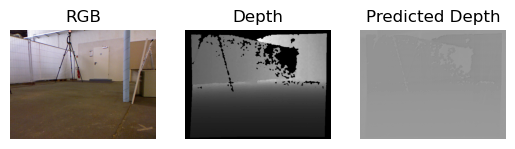

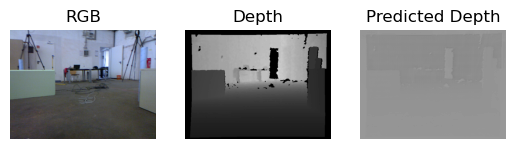

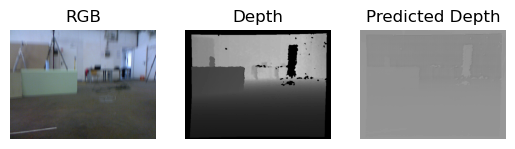

Sample 100/100 - RMSE: 0.36461764574050903, Abs Rel: 0.9895164966583252, Delta1: 0.9809938073158264, Delta2: 0.9939466714859009, Delta3: 0.9989475011825562 
RMSE: 0.36461764574050903, Abs Rel: 0.9895164966583252, Delta1: 0.9809938073158264, Delta2: 0.9939466714859009, Delta3: 0.9989475011825562


In [36]:
import matplotlib.pyplot as plt
import torch
from multitudinous.loss_fns import rmse, rel, delta

NUM_VIZ_SAMPLES = 3
NUM_EVAL_SAMPLES = 100

visualized_count = 0

rmse_total = 0
abs_rel_total = 0
delta1_total = 0
delta2_total = 0
delta3_total = 0
count = 0
total_samples = len(dataloader)

# run inference on the samples
for rgb, depth in dataloader:

    pred = None

    # build the rgb-d sample
    if len(depth.shape) == 2: # if HxW
        rgb = rgb.unsqueeze(0) # unsqueeze the batch dimension
    depth = depth.unsqueeze(1) # unsqueeze the channel dimension
    rgbd = torch.cat((rgb, depth), dim=1)
    
    # run inference
    with torch.no_grad():
        # move the sample to the device
        preds = model(rgbd)

        i = 0

        for p in preds:

            # calculate the metrics
            p = p.squeeze()
            d = depth[i].squeeze()
            r = rgb[i].squeeze()

            rmse_total += rmse(p, d)
            abs_rel_total += rel(p, d)
            delta1_total += delta(p, d, 1.25)
            delta2_total += delta(p, d, 1.25**2)
            delta3_total += delta(p, d, 1.25**3)

            # ----------------------
        
            # visualize the results
            if visualized_count >= NUM_VIZ_SAMPLES:
                continue

            visualized_count += 1

            # plot the results
            plt.subplot(1, 3, 1)
            plt.imshow(r.permute(1, 2, 0))
            plt.title("RGB")
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(d.squeeze(0), cmap="gray")
            plt.title("Depth")
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(p.squeeze(), cmap="gray")
            plt.title("Predicted Depth")
            plt.axis("off")
            plt.show()

            i += 1

    count += BATCH_SIZE

    print(f"\rSample {count}/{NUM_EVAL_SAMPLES} - RMSE: {rmse_total/count}, Abs Rel: {abs_rel_total/count}, Delta1: {delta1_total/count}, Delta2: {delta2_total/count}, Delta3: {delta3_total/count}", end=" ")

    if count >= NUM_EVAL_SAMPLES:
        break

    del pred, rgb, depth

# clean up
del model, dataset, dataloader

# print the metrics
print(f"\nRMSE: {rmse_total/count}, Abs Rel: {abs_rel_total/count}, Delta1: {delta1_total/count}, Delta2: {delta2_total/count}, Delta3: {delta3_total/count}")